# Data analysis 

According to the problem instructions, these are the variables on the datasets: 

**train.csv & test.csv:**  

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee 20usd fee assigned to responsible judgments
    state_fee - 10usd fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations

**train.csv only:**

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant
___

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 

## **Preliminary selection of variables**: 
Based on their description, the following variables seem a reasonable starting choice of features to consider: 
- "violation_street_name",
- "ticket_issued_date",
- "hearing_date",
- "disposition",
- "fine_amount",
- "discount_amount",
- "judgment_amount", 
- "compliance" (target)

The names of agency and inspector issuing the ticket, as well as the name and mailing address of the violator, are left out for the moment. 

Let's drop missing values and check the distributions of the numerical variables:

In [2]:
df1= df[ ["violation_street_name","ticket_issued_date","hearing_date","disposition",
          "fine_amount","discount_amount",
          "judgment_amount", "compliance"]].copy()

print("initial number of tickets: {}".format(len(df1)))
df1.dropna(inplace=True)
print("after droping na values: {}".format(len(df1)))

df1["compliance"].astype("category",inplace=True)
df1.describe()

initial number of tickets: 250306
after droping na values: 159653


,fine_amount,discount_amount,judgment_amount,compliance
count,159653.000000,159653.000000,159653.000000,159653.000000
mean,356.836095,0.167300,420.462796,0.071599
std,675.527243,3.959425,742.445609,0.257824
min,0.000000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,250.000000,0.000000
50%,250.000000,0.000000,305.000000,0.000000
75%,250.000000,0.000000,305.000000,0.000000
max,10000.000000,350.000000,11030.000000,1.000000


<IPython.core.display.Javascript object>


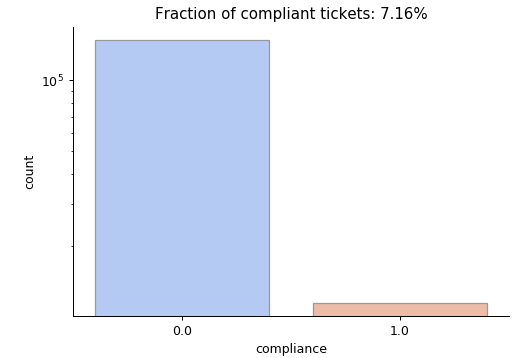

In [63]:
sns.catplot(x="compliance", kind="count", edgecolor=".6", data=df1,palette='coolwarm')
plt.gca().set_title("Fraction of compliant tickets: {:0.2f}%".format( 100*sum(df1.compliance)/len(df1) ))
plt.gca().set_yscale('log')
plt.tight_layout()

## Fine amounts and discounts:

It is reasonable to guess that a discount on a fine may pursue someone to pay it. Lets check the distribution of discount value for *compliants* and *non-compliants*:

<IPython.core.display.Javascript object>


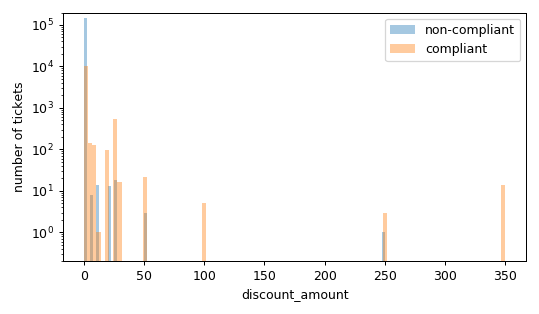

In [84]:
fig1= plt.figure(figsize=(6,3.5))
for i,j in [(0,"non-compliant"),(1,"compliant")]:
        data = df1[df1["compliance"]==i]
        sns.distplot(data["discount_amount"],label=j,hist=True,norm_hist=False,kde=False,bins=100)
plt.gca().set_yscale("log")
plt.gca().set_ylim([2e-1,2e5])
plt.gca().set_ylabel("number of tickets")
plt.legend()
plt.tight_layout()

In [97]:
av_discount_non_comp = df1.where( df1["compliance"]==0.0)["discount_amount"].agg(np.mean)
av_discount_comp     = df1.where( df1["compliance"]==1.0)["discount_amount"].agg(np.mean)
print("averages discount compliant tickets: {:0.3f}".format(av_discount_comp))
print("averages discount non-compliant tickets: {:0.3f}".format(av_discount_non_comp))

averages discount compliant tickets:2.225
averages discount non-compliant tickets:0.009


Though the averages discunts are rather similar, from the distribution histograms can be seen that almost all the non-compliant tickets have no discount, and a *tail* of tickets with no-null discounts is present for the compliants case. Let's see how the *fine* and *judgement amounts* distributions compare with their compliance status:

<IPython.core.display.Javascript object>


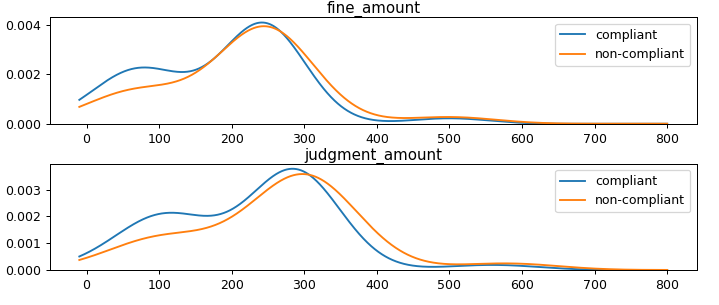

In [99]:
fig2, _ = plt.subplots(2,1,figsize=(8,1.7*2)) 
plt.tight_layout()
for i,var in enumerate(["fine_amount","judgment_amount"]):
    axi=plt.subplot(2,1,i+1)
    for i,j in [(1,"compliant"),(0,"non-compliant")]:
        data = df1[df1["compliance"]==i]
        sns.kdeplot(data[var],label=j,gridsize=2500,clip=(-10,800))
        axi.set_title(var,pad=.15)

Both variables are related as the fine amount is the sum of different values (judgement_amount, additional fees, discount). In both cases the normilized distributions between compliants and non-compliants differ, the former having a two-peak structure and the latter a one-peak shape with larger tails. 

## Time interval between hearing ticket and issuing dates:
One may think that the time intervals between hearing date and the ticket issuing date can have an influence on wheter a ticket is compliant or not:

<IPython.core.display.Javascript object>


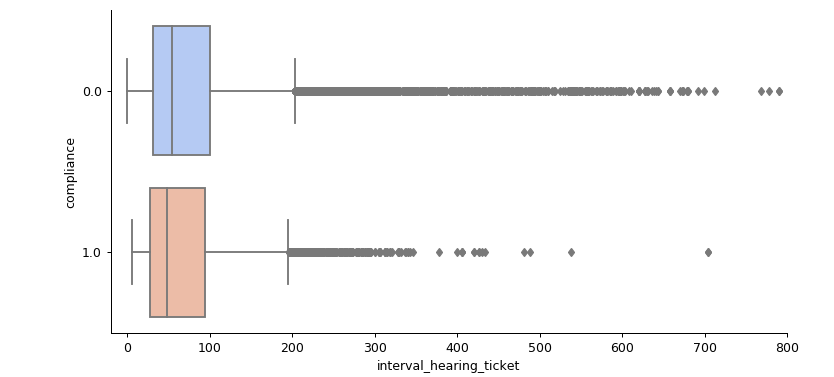

In [100]:
# time interval between hearing and ticket issued date
df1["ticket_issued_date"] = pd.to_datetime(df1["ticket_issued_date"]) #df1["ticket_issued_date"].astype("datetime64[D]")
df1["hearing_date"]=pd.to_datetime(df1["hearing_date"])

df1["interval_hearing_ticket"] = df1.hearing_date - df1.ticket_issued_date
df1["interval_hearing_ticket"] = df1["interval_hearing_ticket"].apply(lambda x: x.days)
sns.catplot(x='interval_hearing_ticket',y='compliance', kind="box",data=df1,orient="horizontal",palette="coolwarm")
plt.gca().set_xlim([-20,800])
plt.tight_layout()

Several remarks should be made from the previous box plot.   
- There are many more non-compliant than compliant cases for intervals >= than ~250 days
- The distributions are rather similar  distributions of quartiles, though their means are not the same. The interval for compliant tickets has a smaller mean.  
- It makes no sense to have a hearing date before the ticket_issued_date, but both distributions present such values so probably it's an error on the data. Let's see how many of these cases are:

In [101]:
print("tickets where hearing date is before ticket_issued date: {}".format( len(df1[ df1.interval_hearing_ticket<0])))
df1.drop(df1[ df1.interval_hearing_ticket<0].index, inplace=True)

tickets where hearing date is before ticket_issued date: 0


<IPython.core.display.Javascript object>


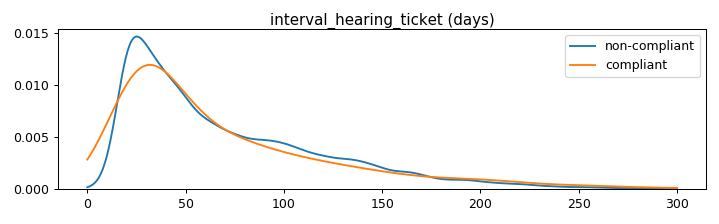

In [103]:
fig4 = plt.figure(figsize=(8,2.5))
for i,j in [(0,"non-compliant"),(1,"compliant")]:
    data = df1[df1["compliance"]==i]
    sns.kdeplot(data["interval_hearing_ticket"],label=j,gridsize=1500,clip=(0,300))
    plt.gca().set_title("interval_hearing_ticket (days)",pad=.15)
fig4.tight_layout()

In [ ]:
# encode non-numerical variables
encoding_lists =[]
non_numerical_vars = ["disposition","violation_street_name"]
for i in non_numerical_vars:
    encoding_list = list(enumerate( df1[i].unique() ))
    encoding_lists.append(  encoding_list  )
    df1[i] = df1[i].apply(  lambda x: [y[0] for y in encoding_list if y[1]==x][0]  )

## Geographical distribution

It is perhaps the most obvious guessing: the compliance of a fine is larger dependent of the street where the violiation takes place, as the ubication in a city tends to reflect things like the economic wealth of the inhabitants. 
In order to visualize the location of the tickets,  the `addresses.csv` and `latlons.csv` files must be first joined (`DataFrame.join`). The resulting dataframe must be joined with the ticket compliance dataframe:

In [17]:
dfa = pd.read_csv("addresses.csv")
dfa.dropna(inplace=True)
#print(len(dfa))
street_parser = lambda x: " ".join( x.split(",")[0].split(" ")[1:]).strip()
address_parser = lambda x: x.split(",")[0].strip()
dfa["street"] = dfa["address"].apply(street_parser)
dfa["address"] = dfa["address"].apply(address_parser)
dfa.head(3)

311307


,ticket_id,address,street
0,22056,2900 tyler,tyler
1,27586,4311 central,central
2,22062,1449 longfellow,longfellow


In [18]:
dflalo = pd.read_csv("latlons.csv")
dflalo.dropna(inplace=True)
dflalo["street"]=dflalo["address"].apply(street_parser)
dflalo["address"]=dflalo["address"].apply(address_parser)
print(len(dflalo) )
dflalo.head(3)

121762


,address,lat,lon,street
0,4300 rosa parks blvd,42.346169,-83.079962,rosa parks blvd
1,14512 sussex,42.394657,-83.194265,sussex
2,3456 garland,42.373779,-82.986228,garland


In [19]:
print(  "Number of different street names in adresses csv: {}".format(len(dfa.street.unique())) )
print(  "Number of different street names in latlon  csv: {}".format(len(dflalo.street.unique())) )
print(  "Number of different street names in train data set: {}".format(len(df1.violation_street_name.unique())) )

Number of different street names in adresses csv: 1831
Number of different street names in latlon  csv: 1830
Number of different street names in train data set: 1716


In [ ]:
df_geoloc = dfa.set_index("address").join(dflalo.set_index("address"),how="left",lsuffix='_caller', rsuffix='_other')
df_geoloc.dropna(inplace=True)
df_geoloc.reset_index(inplace=True)
df_geoloc.set_index("ticket_id",inplace=True)
df_joined = df1.join(df_geoloc,how="left")
#df_joined.head(3)

<IPython.core.display.Javascript object>


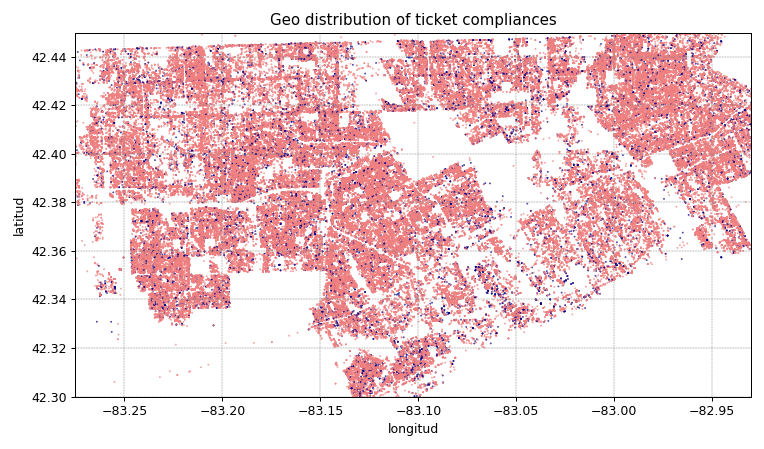

In [106]:
geo_fig = plt.figure(figsize=(8.5,5))
color_code = {0.0:"lightcoral",1.0:"darkblue"}
col = [color_code[i] for i in df_joined["compliance"]]
ax = plt.scatter(df_joined['lon'],df_joined['lat'],c=col,s=0.15,label=col)
ax = plt.gca()
ax.set_xlabel("longitud")
ax.set_ylabel("latitud")
ax.set_title("Geo distribution of ticket compliances")
ax.grid(True,color='grey', linestyle='--', linewidth=.4)
plt.gca().set_xlim([-83.275,-82.93])
plt.gca().set_ylim([42.3,42.45])
plt.tight_layout()

It can be seen that non-compliance of tickets (dark blue points) are common along some some streets. That
will be a good feature for the model.